In [1]:
import music21
import os
from music21 import *

In [2]:
us=music21.environment.UserSettings()
us.restoreDefaults()

In [3]:
music21.environment.set('musescoreDirectPNGPath',str(os.path.join("C:\\", "Program Files","MuseScore 4","bin","MuseScore4.exe")))
music21.environment.set('musicxmlPath', str(os.path.join("C:\\", "Program Files","MuseScore 4","bin","MuseScore4.exe")))
music21.environment.set('lilypondPath', r'C:\Users\jeffs\lilypond-2.24.2\bin\lilypond.exe')


In [4]:
def XML_to_MIDI(file, output_folder,i):
    '''Conversion avec affichage du numero du fichier'''
    
    filename = os.path.splitext(os.path.basename(file))[0]
    musicxml_stream = music21.converter.parse(file,format='musicxml')
    midi_stream=stream.Stream()
    for element in musicxml_stream.flat:
        midi_stream.append(element)
    midi_filename = os.path.join(output_folder, f"{i}_{filename}.midi")
    midi_stream.write('midi', fp=midi_filename)
    print(f"{i} : Fichier MIDI créé : {midi_filename}"+20*" ",end='\r') 

def open_all_xml(folder,x):
    '''Retourne la liste des X premiers objets music21.bases.scores
    du folder contenant des fichiers XML'''
    streams=[]
    for i,file in enumerate(os.listdir(folder)[:x]):
        s=music21.converter.parse(folder+"/"+file)
        streams.append(s)
        print(i+1, "fichiers XML charges"+20*" ",end='\r')
    print(100*" ") 
    print("Chargement termine")
    return streams

#######
#KAGLE#
#######
def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note
                
def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret

def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret


                            


In [5]:
streams=open_all_xml("data_xml",20)

                                                                                                    
Chargement termine


In [6]:
n=0

<class 'music21.stream.base.Score'>


<music21.graph.plot.HistogramPitchClass for <music21.stream.Score 0x269817cd7c8>>

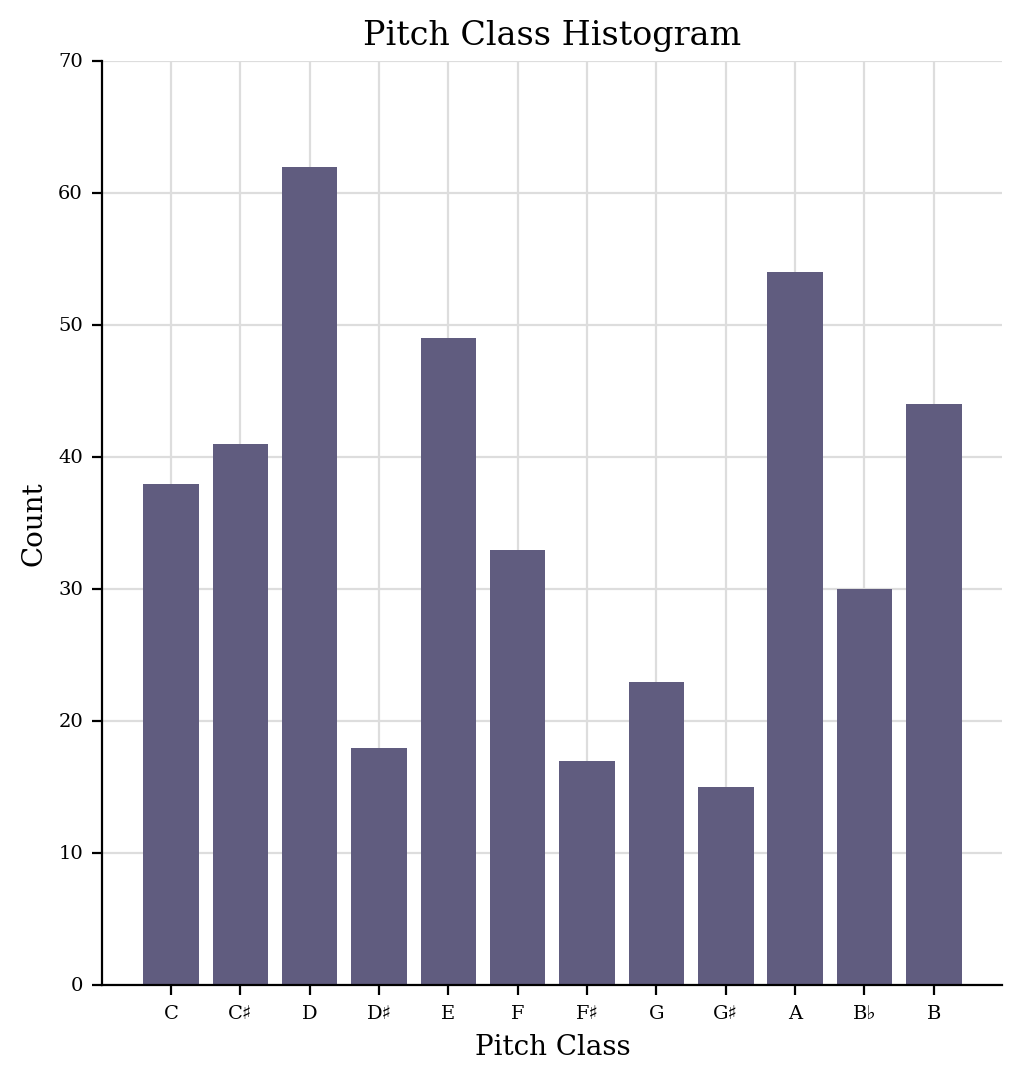

In [7]:
print(streams[n].metadata)
print(type(streams[n]))
streams[n].plot('histogram', 'pitchClass', 'count')

In [8]:
print(harmonic_reduction(streams[n]))

['-', 'iv42', 'v42', 'v7', 'v', 'iv43', '#iii42', 'i42', 'i', 'iv43', '#iii42', 'iv42', 'V', 'iv42', '#iii42', 'i42', 'i', 'vi43', 'bII42', 'iv', '#ii', '#iii', 'iv42', 'III', 'iv42', 'I', 'iv42', 'ii', '#vii7', '#vii42', 'vii', 'III', 'iv42', 'I', 'iv42', 'ii', '#iv', 'ii', 'vi', '#iv', '#vii', 'v', 'iv65', 'ii42', '#vi7', '#iii', 'V', '#ii43', 'i', 'ii42', 'ii42', 'I', '#vi7', '#iii', 'ii43', '#iii', 'vi', 'i', 'I', 'I', '#iii', 'VI6']


In [9]:
streams[0].show('text')

{0.0} <music21.text.TextBox 'A Ginga do...'>
{0.0} <music21.text.TextBox 'Jacob do B...'>
{0.0} <music21.text.TextBox 'Forma A - ...'>
{0.0} <music21.text.TextBox 'Aldo Guina...'>
{0.0} <music21.metadata.Metadata object at 0x26981812188>
{0.0} <music21.stream.Part P1>
    {0.0} <music21.instrument.Instrument 'P1: P1: Flute (2)'>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.expressions.RehearsalMark 'A'>
        {0.0} <music21.expressions.TextExpression 'Intro'>
        {0.0} <music21.layout.PageLayout>
        {0.0} <music21.layout.SystemLayout>
        {0.0} <music21.layout.StaffLayout distance None, staffNumber 1, staffSize None, staffLines None>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of F major>
        {0.0} <music21.meter.TimeSignature 2/4>
        {0.0} <music21.note.Rest whole>
    {0.0} <music21.spanner.RepeatBracket 1 <music21.stream.Measure 22 offset=42.0>>
    {0.0} <music21.spanner.RepeatBracket 2 <music21.stream.Mea

In [10]:
##############
#chat gpt ####
##############
def get_measures_by_sections(score):
    # Créez une liste pour stocker les sections de mesures
    sections = []
    
    # Créez une variable pour stocker la section actuelle
    current_section = stream.Stream()
    
    # Parcourez toutes les mesures de la partition
    for measure in score.recurse().getElementsByClass('Measure'):
        # Vérifiez si la mesure a des crochets de répétition
        repeat_brackets = measure.getElementsByClass('RepeatBracket')
        
        # Si la mesure a des crochets de répétition, créez une nouvelle section
        if repeat_brackets:
            sections.append(current_section)
            current_section = stream.Stream()
        
        # Ajoutez la mesure à la section actuelle
        current_section.append(measure)
    
    # Ajoutez la dernière section à la liste
    if current_section:
        sections.append(current_section)
    
    return sections

def get_measure_indices_for_rehearsal_marks(score):
    rehearsal_marks = score.recurse().getElementsByClass('RehearsalMark')
    measure_indices = []
    
    for mark in rehearsal_marks:
        # Trouver la mesure correspondante à la marque de répétition
        mark_text = str(mark)
        measure = mark.getContextByClass('Measure')
        
        if measure:
            measure_index = measure.number - 1  # Soustraire 1 car les mesures sont généralement indexées à partir de 1
            measure_indices.append((str(mark), measure_index))
    
    return measure_indices


sections = get_measures_by_sections(streams[n])
print(sections)
# Affichez le nombre de sections et le nombre de mesures dans chaque section
for i, section in enumerate(sections):
    print(f"Section {i + 1}: {len(section.getElementsByClass('Measure'))} mesures")

[<music21.stream.Stream 0x26987f302c8>]
Section 1: 62 mesures


In [11]:
# Obtenez les indices de mesure pour les marques de répétition
rehearsal_mark_indices = get_measure_indices_for_rehearsal_marks(streams[n])

for mark, index in rehearsal_mark_indices:
    print(f"Marque de répétition '{mark}' à la mesure {index + 1}")

Marque de répétition '<music21.expressions.RehearsalMark 'A'>' à la mesure 1
Marque de répétition '<music21.expressions.RehearsalMark 'B'>' à la mesure 24
Marque de répétition '<music21.expressions.RehearsalMark 'C'>' à la mesure 41


In [12]:
liste_des_notes = []
score= streams[n]
# Parcourez chaque élément de la partition
for element in score.flat:
    if isinstance(element, music21.note.Note):
        # Si l'élément est une note, ajoutez son nom à la liste
        liste_des_notes.append(f"{element.nameWithOctave}")


In [13]:
print(liste_des_notes)

['C#6', 'D6', 'D#6', 'E6', 'D6', 'B-5', 'G5', 'E5', 'D5', 'C6', 'B-5', 'G5', 'E5', 'D5', 'B-4', 'G4', 'E4', 'D4', 'E4', 'A4', 'B4', 'E5', 'F5', 'G5', 'G#5', 'A5', 'A5', 'C#6', 'D6', 'D#6', 'E6', 'G5', 'G#5', 'A5', 'B-5', 'F6', 'C#6', 'E6', 'E6', 'D6', 'F5', 'G5', 'G#5', 'A5', 'C6', 'B5', 'B-5', 'D5', 'D#5', 'E5', 'C6', 'B5', 'B-5', 'A5', 'A5', 'F5', 'D5', 'B4', 'A4', 'C#6', 'D6', 'D#6', 'E6', 'G5', 'G#5', 'A5', 'B-5', 'F6', 'C#6', 'E6', 'E6', 'D6', 'A5', 'F5', 'E5', 'D5', 'C5', 'D5', 'E5', 'C6', 'A5', 'E5', 'F#5', 'A5', 'G#5', 'B5', 'A5', 'B5', 'C6', 'C#6', 'C#6', 'D6', 'D#6', 'E6', 'G5', 'G#5', 'A5', 'B-5', 'F6', 'C#6', 'E6', 'E6', 'D6', 'F5', 'G5', 'G#5', 'A5', 'C6', 'B5', 'B-5', 'D5', 'D#5', 'E5', 'C6', 'B5', 'B-5', 'A5', 'A5', 'A4', 'B-4', 'B4', 'C5', 'E5', 'F5', 'F#5', 'A5', 'G5', 'G4', 'G#4', 'A4', 'B-4', 'D5', 'E5', 'G5', 'F5', 'F4', 'G4', 'G#4', 'A4', 'D5', 'F5', 'B4', 'A#4', 'B4', 'C#5', 'C#5', 'B#4', 'C#5', 'D5', 'D5', 'C#6', 'D6', 'D#6', 'E6', 'D5', 'E5', 'F5', 'A5', 'D6', '

In [21]:
def get_time_signature(score):
    '''Retourne la signature du temps de la partition en str sinon une str vide'''
    time_signature = None
    for element in score.flat:
        if isinstance(element, meter.TimeSignature):
            time_signature = element
            break
    if time_signature:
        time_signature_name = time_signature.ratioString
        return time_signature_name
    else:
        return ''
score=streams[0]
clefs=[]
pitchs=[]
for element in score.flat:
    if isinstance(element, key.KeySignature):
        clefs.append(element)
    if isinstance(element, music21.pitch.Pitch):
        pitchs.append(element)
        
print(clefs)
print(pitchs)

[<music21.key.Key of F major>, <music21.key.Key of D major>, <music21.key.Key of F major>]
[]


In [15]:
print({'A' : 'La' , 'B' : 'Si' , 'C': 'Do' , 'D' : 'Ré', 'E' : 'Mi' , 'F' : 'Fa' , 'G' : 'Sol' } )

{'A': 'La', 'B': 'Si', 'C': 'Do', 'D': 'Ré', 'E': 'Mi', 'F': 'Fa', 'G': 'Sol'}


In [25]:

def detect_chord_name(notes):
    # Créez un objet Chord en utilisant les notes de l'entrée
    chord_obj = chord.Chord(notes)

    # Essayez de trouver un nom d'accord
    chord_name = chord_obj.commonName
    if chord_name:
        return chord_name
    else:
        return "Note unique"

In [29]:
phrases=[]
for element in score.recurse():
    if isinstance(element, stream.Measure):
        phrases.append(element)

# Maintenant, 'phrases' contient la liste des phrases de la partition.

for i,phrase in enumerate(phrases):
    print(f"Mesure {i+ 1}:")
    notes_tmp=[]
    for element in phrase.notes:
        if isinstance(element, music21.chord.Chord):
            # Si c'est un accord, vous pouvez obtenir les noms de ses notes individuelles
            chord_notes = [note.nameWithOctave for note in element.pitches]
            print(f"  Accord : {', '.join(chord_notes)} (durée : {element.duration.quarterLength} temps)")
        elif isinstance(element, music21.note.Note):
            print(f"  {element.nameWithOctave} (durée : {element.duration.quarterLength} temps)")
            notes_tmp.append(element)
    print(detect_chord_name(notes_tmp))

Mesure 1:
empty chord
Mesure 2:
  C#6 (durée : 0.25 temps)
  D6 (durée : 0.25 temps)
  D#6 (durée : 0.25 temps)
chromatic trimirror
Mesure 3:
  E6 (durée : 0.5 temps)
  D6 (durée : 0.5 temps)
  B-5 (durée : 0.25 temps)
  G5 (durée : 0.25 temps)
  E5 (durée : 0.25 temps)
  D5 (durée : 0.25 temps)
half-diminished seventh chord
Mesure 4:
  C6 (durée : 0.25 temps)
  B-5 (durée : 0.25 temps)
  G5 (durée : 0.25 temps)
  E5 (durée : 0.25 temps)
  D5 (durée : 0.25 temps)
  B-4 (durée : 0.25 temps)
  G4 (durée : 0.25 temps)
  E4 (durée : 0.25 temps)
dominant-ninth
Mesure 5:
  D4 (durée : 0.25 temps)
  E4 (durée : 0.25 temps)
  A4 (durée : 0.25 temps)
  B4 (durée : 0.25 temps)
  E5 (durée : 0.25 temps)
  F5 (durée : 0.25 temps)
  G5 (durée : 0.25 temps)
  G#5 (durée : 0.25 temps)
forte class 7-25B
Mesure 6:
  A5 (durée : 0.75 temps)
  A5 (durée : 0.25 temps)
  C#6 (durée : 0.25 temps)
  D6 (durée : 0.25 temps)
  D#6 (durée : 0.25 temps)
major third tetracluster
Mesure 7:
  E6 (durée : 0.25 temps